# Импорты 💻

Импорты для Текста

In [39]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from navec import Navec

import pymorphy2

import re

Общие импорты

In [2]:
import numpy as np
import pandas as pd

Импорты для модели

In [3]:
from keras.models import Sequential, Input, load_model
from keras.layers import Dense, LSTM, SpatialDropout1D
from keras.models import load_model

from random import sample

import pickle

Using TensorFlow backend.


Магические слова для тетрадки

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/gpu/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Настройка работы с текстом (загрузка) 💼

Необходимо загрузить модель для токенизации

In [30]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

In [36]:
navec = Navec.load(path)
morph = pymorphy2.MorphAnalyzer()

Пример текста

In [7]:
profile = "Я хочу быть дизайнером, но получается программистом, возьмите на работу пожалуйста"

Токенизируем

In [8]:
token = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', profile) if  c not in '.,!()-:?' ))

In [9]:
token

['хочу',
 'быть',
 'дизайнером',
 'получается',
 'программистом',
 'возьмите',
 'работу',
 'пожалуйста']

## Русский Word2vec 🎓

In [10]:
token_vectors = np.array([navec[x] for x in token])

In [11]:
print(token_vectors.shape)

(8, 300)


## Грузим данные из твиттов, на них поучимся 👀

In [127]:
positive = pd.read_csv("train_data/positive.csv", delimiter=";", index_col=False)
negative = pd.read_csv("train_data/negative.csv", delimiter=";", index_col=False)
positive['ttext'] = positive['ttext'].apply(lambda x: x.lower())
positive['ttext'] = positive['ttext'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
negative['ttext'] = negative['ttext'].apply(lambda x: x.lower())
negative['ttext'] = negative['ttext'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [128]:
negative.head()

,id,tdate,tmane,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,d,-1,0,0,0,8064,111,94
1,408906818262687744,1386325957,nugemycejela,urban terror,-1,0,0,0,26,42,39
2,408906858515398656,1386325966,4post21,elina_4post,-1,0,0,0,718,49,249
3,408906914437685248,1386325980,Poliwake,httptcojclnzvnv3s,-1,0,0,0,10628,207,200
4,408906914723295232,1386325980,capyvixowe,surf,-1,0,0,0,35,17,34


## Готовим обучающую и тестовую выборку 📚

In [24]:
X = np.hstack([positive["ttext"].values[:50000] , negative["ttext"].values[:50000]])
y = (np.hstack([positive["ttype"].values[:50000] , negative["ttype"].values[:50000]]) + 1) / 2
y = np.eye(2)[y.reshape(-1).astype(np.int8)]

In [26]:
print(X.shape, y.shape, X.shape == y.shape)

(100000,) (100000, 2) False


In [24]:
def vectorizator(X:np.array, max_lenth=None, verbose=False):
    """Функция производит векторизацию входного текста.
    Arguments:
        X (np.array) - массив из текстов
        max_lenth (int) - максимальная длинна текста (число слов). Для нашей модели длинна 18, если оставить None - посчитает эту длинну. default=None
        verbose (bool) - вывод информации о максимальной длинне (max_lenth), по умолчанию отключена. default=False
    Returns:
        vec (np.array) - массив векторов (эмбедингов) для текста, размерность len(X) x max_lenth x 300
    """
    tokens = []
    if max_lenth == None:
        max_lenth = 0
        flag_to_compute = True
    else:
        flag_to_compute = False
        
    for i in X:
        tokens.append(word_tokenize(''.join( c for c in re.sub(r'', '', i) if  c not in '.,!()-:?' )))
        if flag_to_compute == True and len(tokens[-1]) > max_lenth:
            max_lenth = len(tokens[-1])
    
    if verbose:
        print(f"Максимальная длинна сообщения: {max_lenth}")
    
    for i in range(len(tokens)):
        tokens[i].extend([0 for x in range(max_lenth - len(tokens[i]))])
    
    vec = np.ndarray(shape=(len(X), max_lenth, 300))
    
    for phrase in range(len(tokens)):
        for word in range(len(tokens[phrase])):
            if tokens[phrase][word] == 0:
                vec[phrase, word] = np.zeros(shape = (1, 300))
            else:
                try :
                    vec[phrase, word] = navec[tokens[phrase][word].lower()]
                except KeyError:
                    vec[phrase, word] = np.zeros(shape = (1, 300))
    
    return vec

In [27]:
X = vectorizator(X, None)

Максимальная длинна сообщения: 18


In [25]:
np.save("/home/gpu/DataDrive/TempData/X", X)
np.save("/home/gpu/DataDrive/TempData/y", y)

## LSTM модель 😌

In [7]:
X = np.load("/home/gpu/DataDrive/TempData/X.npy")
y = np.load("/home/gpu/DataDrive/TempData/y.npy")

In [13]:
test_idx = sample(range(0, len(X)), int(len(X) / 10))

In [32]:
sentiment_predictor = Sequential()

sentiment_predictor.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, input_shape=(18,300)))
sentiment_predictor.add(Dense(50,activation='sigmoid'))
sentiment_predictor.add(Dense(25,activation='sigmoid'))
sentiment_predictor.add(Dense(5,activation='sigmoid'))
sentiment_predictor.add(Dense(2,activation='softmax'))
sentiment_predictor.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(sentiment_predictor.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
Total params: 412,267
Trainable params: 412,267
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history = sentiment_predictor.fit(
    x=np.delete(X, test_idx, 0),
    y=np.delete(y, test_idx, 0),
    batch_size=10000,
    epochs=10,
    verbose=1,
    callbacks=None,
    validation_data=(X[test_idx], y[test_idx]),
    shuffle=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 90000 samples, validate on 10000 samples
Epoch 1/10





90000/90000 [==============================] - 18s 203us/step - loss: 0.8520 - acc: 0.5004 - val_loss: 0.8222 - val_acc: 0.4961
Epoch 2/10
90000/90000 [==============================] - 11s 118us/step - loss: 0.7846 - acc: 0.5004 - val_loss: 0.7482 - val_acc: 0.4961
Epoch 3/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7322 - acc: 0.5004 - val_loss: 0.7209 - val_acc: 0.4961
Epoch 4/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7122 - acc: 0.5004 - val_loss: 0.7063 - val_acc: 0.4961
Epoch 5/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.7005 - acc: 0.5004 - val_loss: 0.6967 - val_acc: 0.4961
Epoch 6/10
90000/90000 [==============================] - 11s 117us/step - loss: 0.6917 - acc: 0.5004 - val_loss: 0.6895 - val_acc: 0.4961
Epoch 7/10
900

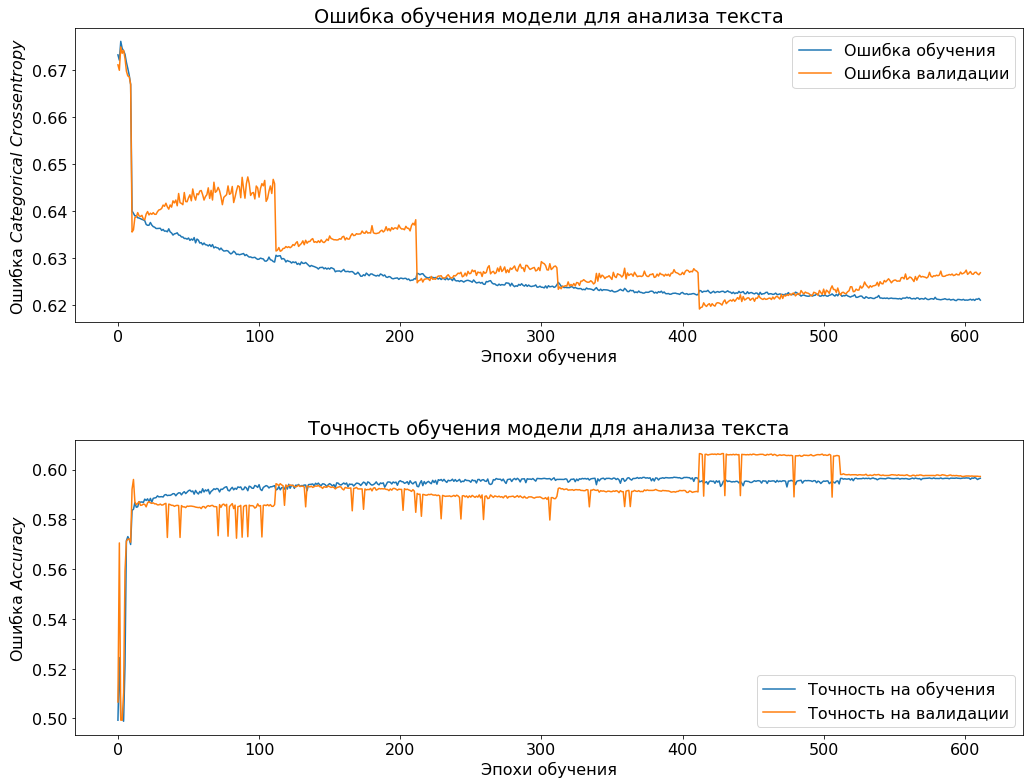

In [32]:
with open('train_history.pickle', 'rb') as f:
    history = pickle.load(f)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 1, figsize=(17,13))

ax[0].plot(history['loss'], label=f"Ошибка обучения")
ax[0].plot(history['val_loss'], label=f"Ошибка валидации")
ax[0].set_xlabel("Эпохи обучения")
ax[0].set_ylabel(r"Ошибка $Categorical$ $Crossentropy$")
ax[0].set_title(f"Ошибка обучения модели для анализа текста")
ax[0].legend(loc="best")

ax[1].plot(history['acc'], label=f"Точность на обучения")
ax[1].plot(history['val_acc'], label=f"Точность на валидации")
ax[1].set_xlabel("Эпохи обучения")
ax[1].set_ylabel(r"Ошибка $Accuracy$")
ax[1].set_title(f"Точность обучения модели для анализа текста")
ax[1].legend(loc="best")

plt.subplots_adjust(hspace=0.4)
plt.savefig("graphs/train_info.svg", dpi=200)
plt.show()

## Применение модели 🤔

In [14]:
sentiment_predictor = load_model("sentiment_predictor")

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [15]:
text = [
    u"Самая тупая работа, лучше б и не приходил, ненависть!",
    u"Обожаю вашу компанию, хочу работать только у вас!"
]
new_entry = vectorizator(text, 18)

Максимальная длинна сообщения: 18


In [16]:
predict = sentiment_predictor.predict_classes(new_entry)

In [17]:
prediction_encode = {0: "Негативная окраска", 1: "Позитивная окраска"}
print(f"{text[0]} -- {prediction_encode[predict[0]]}\n{text[1]} -- {prediction_encode[1]}")

Самая тупая работа, лучше б и не приходил, ненависть! -- Негативная окраска
Обожаю вашу компанию, хочу работать только у вас! -- Позитивная окраска


## Подсвечиваем слова для модели 👍

In [123]:
text = "Хотелось бы работать в развивающейся компании"

In [124]:
def predictor_mark_words(model, text: str):
    """Возвращает слова, наиболее повлиявшие на оценку
    Arguments:
        model (keras.Model): модель обученной сети (грузиться из файла sentiment_predictor с помощью pickle)
        text (str): проверяемый текст
    Returns:
        words (np.array): одномерный массив с 3мя наиболее повлиявшими на оценку словами
    """
    
    vec = vectorizator([text], 18)   
    for w in text.split(" "):
        temp_text = ''.join([str(c) + " " for c in text.split(" ") if  c != w])
        vec = np.vstack([vec, vectorizator([temp_text], 18, verbose=False)])
    predict = sentiment_predictor.predict_proba(vec)
    res = np.argmax(a[0])
    marks = predict[1:, res].argsort()[-3:][::-1]
    return np.asarray(text.split(" "))[marks]

In [125]:
a = predictor_mark_words(sentiment_predictor, text)

In [126]:
print(a, prediction_encode[sentiment_predictor.predict_classes(vectorizator([text], 18))[0]])

['развивающейся' 'компании' 'работать'] Позитивная окраска


# Аналитика по вакансиям 🏊

### Базы вакансий и резюме по ЦФО 🏙

In [8]:
vacancies = pd.read_csv("train_data/vacancies_all.csv")

In [14]:
vacancies.head(2)

,min_salary,max_salary,title,employment_type,work_hours,responsibilities,education_requirements,experience_requirements,job_location,required_drive_license
0,60000,60000,Машинист крана (крановщик),Полная занятость,Ненормированный рабочий день,"Управление гусеничным краном, оснащенным разли...",Среднее профессиональное,5,г. Москва,"[C, D, E]"
1,70000,75000,Инженер-строитель,Полная занятость,Ненормированный рабочий день,Инженер строитель выполняет технический надзор...,Высшее,5,г. Москва,NaN


In [13]:
test_data = vacancies[vacancies["title"].str.lower().str.contains("программист")]

## Частотный анализ текстов вакансий IT-специалистов 🔍

In [250]:
text_all_merged = ""
text_all = [str(x) + "\n" for x in test_data['responsibilities'].dropna().values]
print("Корректных сообщений:", len(text_all))

for i in text_all:
    text_all_merged += i.lower()
    
print("Всего символов:", len(text_all_merged), "Тип объекта:", type(text_all_merged))

Корректных сообщений: 673
Всего символов: 153342 Тип объекта: <class 'str'>


In [251]:
vacancies

,min_salary,max_salary,title,employment_type,work_hours,responsibilities,education_requirements,experience_requirements,job_location,required_drive_license
0,60000,60000,Машинист крана (крановщик),Полная занятость,Ненормированный рабочий день,"Управление гусеничным краном, оснащенным разли...",Среднее профессиональное,5,г. Москва,"[C, D, E]"
1,70000,75000,Инженер-строитель,Полная занятость,Ненормированный рабочий день,Инженер строитель выполняет технический надзор...,Высшее,5,г. Москва,NaN
2,60000,60000,Техник,Полная занятость,Ненормированный рабочий день,"Работа на объектах, управлять техникой занятой...",Среднее профессиональное,5,г. Москва,NaN
3,70000,70000,Машинист буровой установки,Полная занятость,Ненормированный рабочий день,Управление буровыми установками различного ти...,Среднее профессиональное,5,г. Москва,"[B, C, E]"
4,6723,0,Психолог,Временная,Неполный рабочий день,"Осуществлять профессиональную деятельность, на...",Среднее профессиональное,0,Калужская область,NaN
...,...,...,...,...,...,...,...,...,...,...
99713,17250,17250,Лаборант,Полная занятость,Сменный график,"1. Выполняет лабораторные анализы, испытания, ...",Среднее профессиональное,0,Орловская область,NaN
99714,23000,23000,Методист,Временная,Ненормированный рабочий день,"оставление планов, подготовка дидактических ма...",Высшее,0,Тамбовская область,NaN
99715,25000,45000,Мойщик автомобилей,Полная занятость,Сменный график,Производит мойку автотранспортных средств с по...,Среднее,0,Калужская область,NaN
99716,40000,0,Мастер по ремонту оборудования,Полная занятость,Полный рабочий день,Общие обязанности: Знание и выполнение должно...,Среднее профессиональное,3,Московская область,NaN


In [252]:
token_data = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', text_all_merged) if  c not in '</>.,!()-:?;&' ))
print(f"Уникальных слов {len(token)} штук, более 3 букв")

Уникальных слов 13478 штук, более 3 букв


In [253]:
normalize_token = []
for i in token_data:
    normalize_token.append(morph.parse(i)[0].normal_form)

In [254]:
fdist = FreqDist(normalize_token)

In [51]:
def sorting_struct_nltk(count):
    """Сортировка слов по числу вхожденй в текст
    Arguments:
        count (nltk.FreqDist): структура 'слово' - 'число вхождений в текст' 
    Returns:
        df (pd.DataFrame): отсортированный датафрейм, столбцы: x - слово, y - число вхождений 
    """
    
    df = pd.DataFrame(columns=("x", "y"))
    for i in range(len(count)):
        if str(count[i][1]).isnumeric():
            df = df.append({"x" : str(count[i][0]), "y" : int(count[i][1])}, ignore_index=True)
    df = df.sort_values(by=['y'], ascending=False)
    return df

In [67]:
def take_bigrams(token, size):
    """Получение биграмм из токенизированного текста
    Arguments:
        token (list): список токенов из исходного текста
        size (int): минимальное вхождения биграмм в исходный текст
    Returns:
        bigram_freq (lsit): список списков ['биграмма', 'частота вхождений']
    """
    
    bgs = nltk.bigrams(token)
    bigram_freq = []
    fdist = nltk.FreqDist(bgs)

    for k,v in fdist.items():
        if v > size:
            bigram_freq.append([k,v])
            
    return bigram_freq

In [79]:
bg_num = []
for i in range(1,50):
    bg_num.append(len(take_bigrams(token_data, i)))

### Наиболее часто встречающеся слова, биграммы 🧮

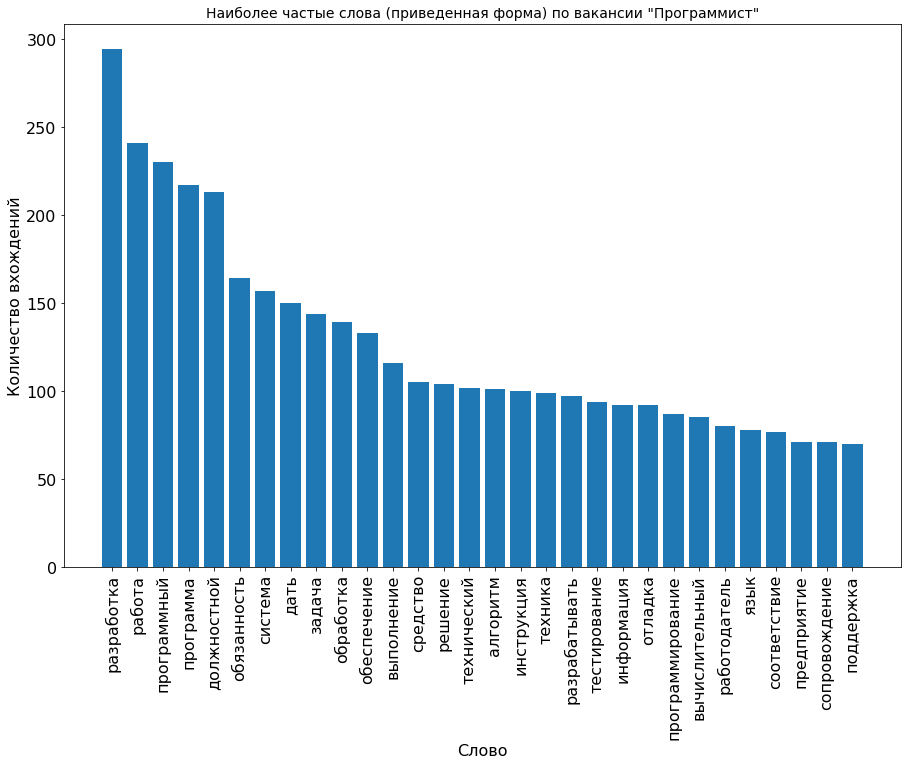

In [255]:
pl = sorting_struct_nltk(fdist.most_common(30))
fig, ax = plt.subplots(1, figsize=(15,10))
ax.bar(pl.x.values, pl.y.values)
plt.rcParams.update({'font.size': 16})
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)
plt.xticks(np.arange(len(pl)), [str(x) for x in pl.x.values], rotation=90)
plt.xlabel("Слово")
plt.ylabel("Количество вхождений")
plt.title("Наиболее частые слова (приведенная форма) по вакансии \"Программист\"")
plt.savefig("graphs/words_norm.png", dpi=200,  bbox_inches = 'tight')
fig.show()

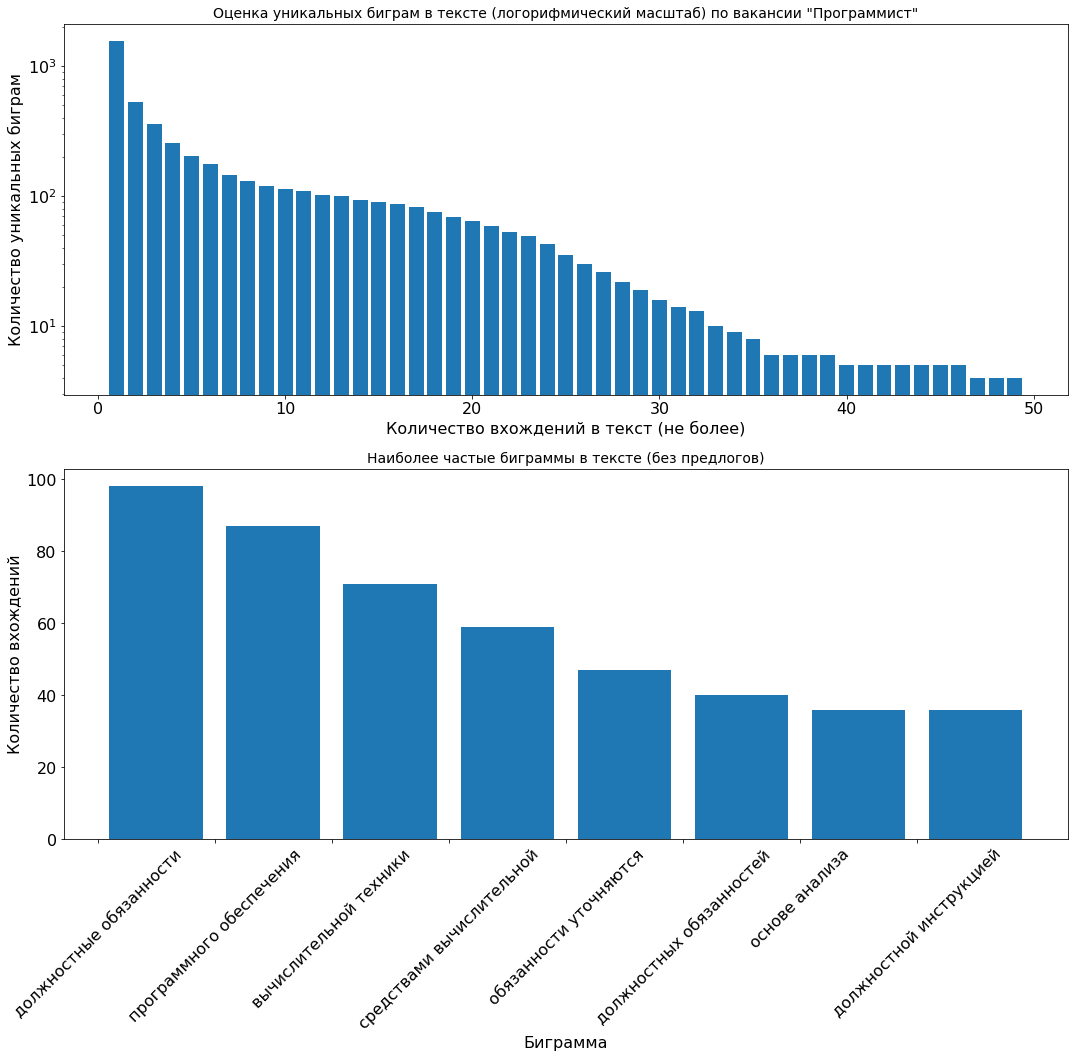

In [203]:
bigram_freq = take_bigrams(token_data, 35)
pl_bigram = pd.DataFrame({"x" : [x[0][0] + " " + x[0][1] for x in bigram_freq], "y" : [x[1] for x in bigram_freq]})
pl_bigram = pl_bigram.sort_values(by=['y'], ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(18,15))
ax[0].bar([x for x in range(1,50)], bg_num)
ax[0].set_xlabel("Количество вхождений в текст (не более)")
ax[0].set_ylabel("Количество уникальных биграм")
ax[0].set_title("Оценка уникальных биграм в тексте (логорифмический масштаб) по вакансии \"Программист\"")
ax[0].set_yscale('log')

ax[1].bar(pl_bigram.x.values, pl_bigram.y.values)
ax[1].set_xticks(np.arange(len(pl_bigram)) - 0.5)
ax[1].set_xticklabels([str(x) for x in pl.x.values], rotation=45)
ax[1].set_xlabel("Биграмма")
ax[1].set_ylabel("Количество вхождений")
ax[1].set_title("Наиболее частые биграммы в тексте (без предлогов)")
fig.show()
plt.savefig("graphs/bigrams.png", dpi=200,  bbox_inches = 'tight')

### Собираем аналитику в одну функцию 📊

In [92]:
def frame_vacancies_analytic(data: pd.DataFrame, column, verbose=True):
    """Получение аналитики по вакансиям (на проде не надо!)
    Arguments:
        data (pd.DataFrame): датасет содержащий столбец с текстовыми описаниями вакансий
        column (str): имя столбца с текстовыми описаниями вакансий
        verbose (bool): отображение информации при выполнении default=True
    Returns:
        pl (pd.DataFrame): датафрейм с частотами вхождений слов (см. sorting_struct_nltk())
        pl_bigraM (pd.DataFrame): датафрейм с частотами вхождения биграм (см. take_bigrams())
    """
    text_all_merged = ""
    text_all = [str(x) + "\n" for x in data[column].dropna().values]
    if verbose:
        print("Корректных сообщений:", len(text_all))

    for i in text_all:
        text_all_merged += i.lower()
    if verbose:
        print("Всего символов:", len(text_all_merged), "Тип объекта:", type(text_all_merged))
        
    token_data = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', text_all_merged) if  c not in '</>.,!()-:?;&' ))
    if verbose:
        print(f"Уникальных слов {len(token)} штук, более 3 букв")
        
    normalize_token = []
    for i in token_data:
        normalize_token.append(morph.parse(i)[0].normal_form)
        
    fdist = FreqDist(normalize_token)
    pl = sorting_struct_nltk(fdist.most_common(30))
    bg_num = []
    for i in range(1,50):
        bg_num.append(len(take_bigrams(token_data, i)))
        
    
    bigram_freq = take_bigrams(token_data, 35)
    pl_bigram = pd.DataFrame({"x_bigram" : [x[0][0] + " " + x[0][1] for x in bigram_freq], "y_bigram" : [x[1] for x in bigram_freq]})
    pl_bigram = pl_bigram.sort_values(by=['y_bigram'], ascending=False)
    
    return pl, pl_bigram

In [96]:
words, bigrams = frame_vacancies_analytic(vacancies[vacancies["title"].str.lower().str.contains("программист")])

Корректных сообщений: 673
Всего символов: 153342 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв


### Формируем общую аналитическую базу 🔮

In [156]:
words = pd.DataFrame(columns=["x", "y", "vac"])
bigrams = pd.DataFrame(columns=["x_bigram", "y_bigram", "vac"])
for vac in ["программист", "дизайнер компьютерной", "системный администратор", "тестировщик", "разработчик"]:
    temp_words, temp_bigrams = frame_vacancies_analytic(vacancies[vacancies["title"].str.lower().str.contains(vac)])
    temp_words["vac"] = vac
    temp_bigrams["vac"] = vac
    words = words.append(temp_words, ignore_index=True)
    bigrams = bigrams.append(temp_bigrams, ignore_index=True)
    print("\n")

Корректных сообщений: 673
Всего символов: 153342 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв


Корректных сообщений: 37
Всего символов: 6984 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв


Корректных сообщений: 116
Всего символов: 41573 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв


Корректных сообщений: 4
Всего символов: 1385 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв


Корректных сообщений: 29
Всего символов: 8185 Тип объекта: <class 'str'>
Уникальных слов 13478 штук, более 3 букв




In [129]:
words.to_csv("train_data/words_statistic.csv", index=False)
bigrams.to_csv("train_data/bigrams_statistic.csv", index=False)

### Подсвечиваем наиболее частые / уникальные (не включенные в статистику) слова и биграммы 📝

In [152]:
def mark_text_vacancies(text, vac_type, words, bigrams, freq=True):
    """Подсвечивание в тексте вакансии наиболее частых/редких слов и биграмм
    Arguments:
        text (str): текст проверяемой вакансии
        vac_type (str): группа вакансий - одна из ["программист", "дизайнер компьютерной", "системный администратор", "тестировщик", "разработчик"]
        words (pd.DataFrame): статистика по словам (см. frame_vacancies_analytic())
        bigrams (pd.DataFrame): статистика по биграммам (см. frame_vacancies_analytic())
        freq (bool): если True - возвращаем наиболее частые слова/биграммы, если False - ранее не знакомые (нет в words и bigrams) default=True
    Returns:
        words_mark (list): список подсвеченных слов 
        bigrams_mark (list): список подсвеченных биграмм
    """
    text = text.lower()
    token_data = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', text) if  c not in '</>.,!()-:?;&' ))
    
    words = words[words["vac"] == vac_type]
    bigrams = bigrams[bigrams["vac"] == vac_type]
    
    normalize_token = []
    for i in token_data:
        normalize_token.append(morph.parse(i)[0].normal_form)
    fdist = FreqDist(normalize_token)
    
    pl = sorting_struct_nltk(fdist.most_common(20))
    pl = pl[pl["y"] > 1]
    
    words_mark = []
    for i in pl.x.values:
        if freq:
            words_mark.extend([i for x in range(1) if len(words[words["x"].str.lower().str.contains(i)]) > 0])
        else:
            words_mark.extend([i for x in range(1) if len(words[words["x"].str.lower().str.contains(i)]) == 0])
    
    bigrams_mark = []
    
    bigram_freq = take_bigrams(token_data, 0)
    pl_bigram = pd.DataFrame({"x_bigram" : [x[0][0] + " " + x[0][1] for x in bigram_freq], "y_bigram" : [x[1] for x in bigram_freq]})
    pl_bigram = pl_bigram.sort_values(by=['y_bigram'], ascending=False)
    
    for i in pl_bigram.x_bigram.values:
        if freq:
            bigrams_mark.extend([i for x in range(1) if len(bigrams[bigrams["x_bigram"].str.lower().str.contains(i)]) > 0])
        else:
            bigrams_mark.extend([i for x in range(1) if len(bigrams[bigrams["x_bigram"].str.lower().str.contains(i)]) == 0])
    
    return words_mark, bigrams_mark
        

In [153]:
test_vac = "Определяет информацию, подлежащую обработке средствами вычислительной техники, ее объемы, структуру, макеты и схемы ввода, обработки, хранения и вывода, методы ее контроля. Выполняет работу по подготовке программ к отладке и проводит отладку."

In [155]:
print(mark_text_vacancies(test_vac, vac_type="программист", freq=True))

(['обработка', 'отладка'], ['вычислительной техники', 'средствами вычислительной'])


### Численные данные по вакансиям 🗄

In [190]:
vacancies[["min_salary", "max_salary", "experience_requirements"]][
    (vacancies["title"].str.lower().str.contains("программист")) & 
    (vacancies["min_salary"] > 0) & (vacancies["max_salary"] > 0)
].describe()

,min_salary,max_salary,experience_requirements
count,374.000000,374.000000,374.000000
mean,38046.149733,44043.275401,1.834225
std,29376.916178,35474.200558,1.896605
min,12130.000000,12130.000000,0.000000
25%,18000.000000,20000.000000,0.000000
50%,30000.000000,36500.000000,1.000000
75%,45000.000000,50000.000000,3.000000
max,180000.000000,300000.000000,12.000000


In [196]:
numeric_data_vacancies = pd.DataFrame()
for vac in ["программист", "дизайнер компьютерной", "системный администратор", "тестировщик", "разработчик"]:
    temp_stat = vacancies[["min_salary", "max_salary", "experience_requirements"]][
        (vacancies["title"].str.lower().str.contains(vac)) & 
        (vacancies["min_salary"] > 0) & (vacancies["max_salary"] > 0)
    ].describe()
    temp_dict = {"vac" : vac}
    for stat in temp_stat.columns:
        temp_dict[str(stat) + "_min"] = temp_stat[stat]["min"]
        temp_dict[str(stat) + "_max"] = temp_stat[stat]["max"]
        temp_dict[str(stat) + "_mean"] = temp_stat[stat]["mean"]
        temp_dict[str(stat) + "_50"] = temp_stat[stat]["50%"]
    numeric_data_vacancies = numeric_data_vacancies.append(temp_dict, ignore_index=True)

In [200]:
numeric_data_vacancies.to_csv("train_data/numeric_data_vacancies.csv", index=False)
numeric_data_vacancies.set_index("vac").T

vac,программист,дизайнер компьютерной,системный администратор,тестировщик,разработчик
experience_requirements_50,1.000000,2.000000,0.000000,3.0,3.00
experience_requirements_max,12.000000,3.000000,5.000000,3.0,3.00
experience_requirements_mean,1.834225,1.545455,0.984615,3.0,2.75
experience_requirements_min,0.000000,0.000000,0.000000,3.0,2.00
max_salary_50,36500.000000,22320.000000,25000.000000,30000.0,30000.00
max_salary_max,300000.000000,75000.000000,100000.000000,30000.0,170000.00
max_salary_mean,44043.275401,32115.454545,29119.000000,30000.0,50000.00
max_salary_min,12130.000000,12130.000000,6065.000000,30000.0,20000.00
min_salary_50,30000.000000,22320.000000,20000.000000,30000.0,30000.00
min_salary_max,180000.000000,40000.000000,80000.000000,30000.0,110000.00


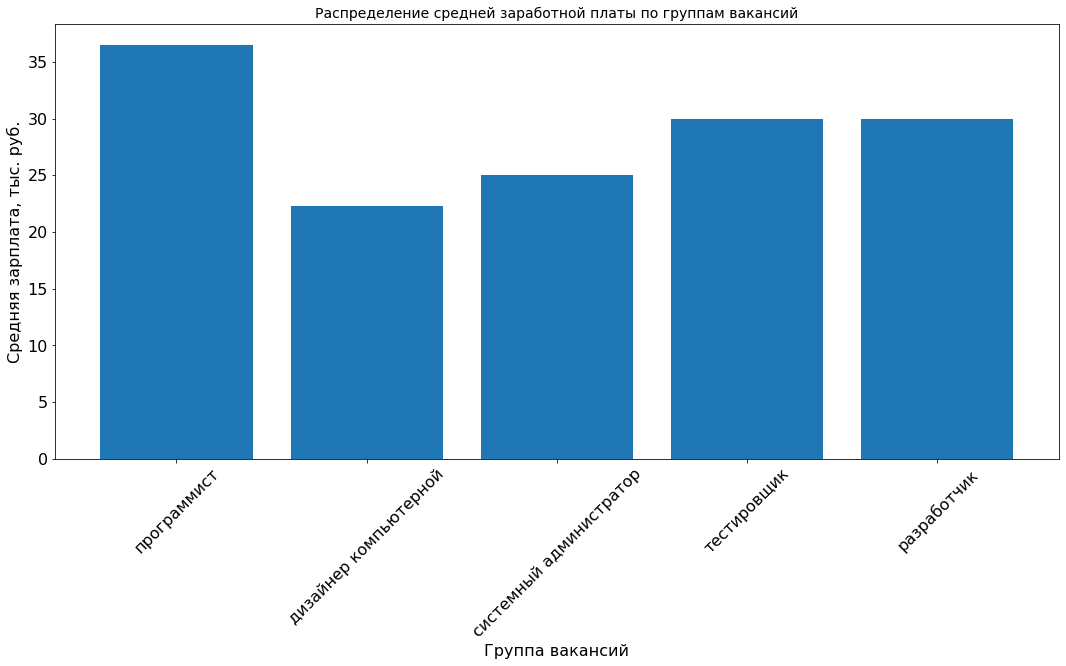

In [199]:
fig, ax = plt.subplots(1, figsize=(18,8))
plt.rcParams.update({'font.size': 16})
plt.bar(np.arange(5), numeric_data_vacancies["max_salary_50"] / 1000)
plt.xlabel("Группа вакансий")
plt.ylabel("Средняя зарплата, тыс. руб.")
plt.title("Распределение средней заработной платы по группам вакансий")
plt.xticks(np.arange(5), [str(x) for x in numeric_data_vacancies["vac"]], rotation=45)

plt.savefig("graphs/salary.png", dpi=200,  bbox_inches = 'tight')

plt.show()

## Аналитика по резюме 🙀

In [210]:
res_data = pd.read_csv("/home/gpu/DataDrive/TempData/cvs_result.csv")

In [212]:
res_data.head()

,position_name,education_type,qualification,additional_education,drive_licence,salary,busy_type,birthday_year,gender
0,Специалист,Высшее,экономист,NaN,NaN,20000,Полная занятость,1967,Женский
1,Специалист,NaN,NaN,NaN,NaN,20000,Полная занятость,1967,Женский
2,Экономист,Высшее,NaN,NaN,NaN,20000,Полная занятость,1967,Женский
3,Главный специалист,Высшее,NaN,NaN,NaN,20000,Полная занятость,1967,Женский
4,"Специалист, главный",Высшее,NaN,NaN,NaN,20000,Полная занятость,1967,Женский


сбрасывыем резюме без желаемой позиции

In [257]:
res_data = res_data[res_data['position_name'].notna()]

In [258]:
test_res_data = res_data[res_data["position_name"].str.lower().str.contains("программист")]

In [273]:
test_res_data = test_res_data[(test_res_data["salary"] > 15000) & (test_res_data["salary"] < 500000)]

In [259]:
text_all_merged = ""
text_all = [str(x) + "\n" for x in res_data['qualification'].dropna().values]

for i in text_all:
    text_all_merged += i.lower()
token_data_res = word_tokenize(''.join( c for c in re.sub(r'\b\w{1,3}\b', '', text_all_merged) if  c not in '</>.,!()-:?;&\'\"`' ))

normalize_token = []
for i in token_data_res:
    normalize_token.append(morph.parse(i)[0].normal_form)
    
fdist = FreqDist(normalize_token)

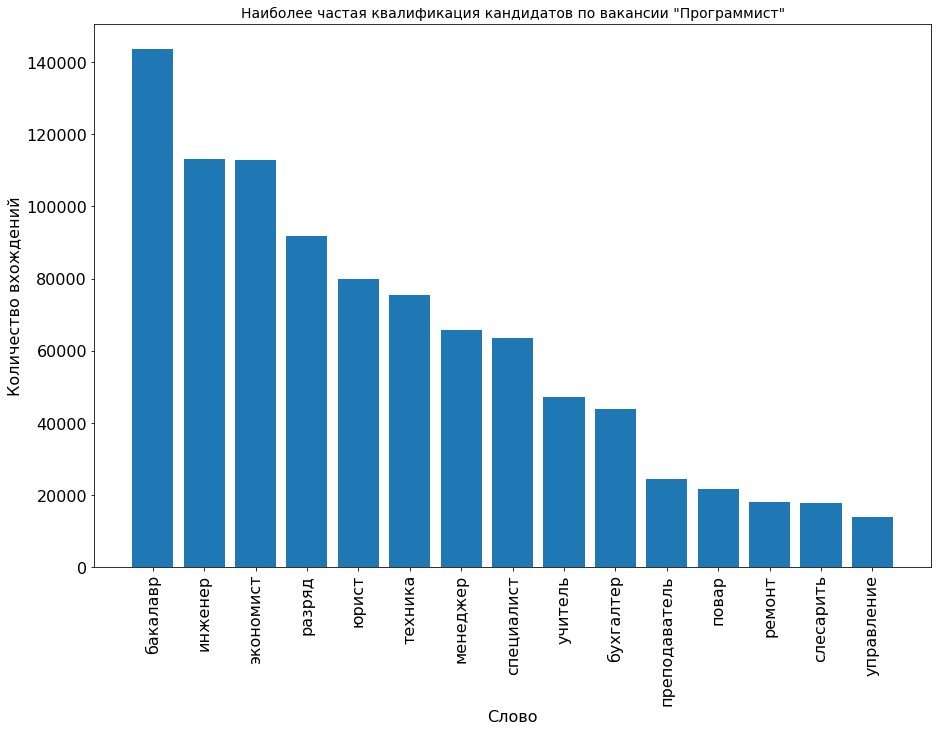

In [260]:
pl = sorting_struct_nltk(fdist.most_common(20)).drop([10, 13, 14, 17, 18])
fig, ax = plt.subplots(1, figsize=(15,10))
ax.bar(pl.x.values, pl.y.values)
plt.rcParams.update({'font.size': 16})
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)
plt.xticks(np.arange(len(pl)), [str(x) for x in pl.x.values], rotation=90)
plt.xlabel("Слово")
plt.ylabel("Количество вхождений")
plt.title("Наиболее частая квалификация кандидатов по вакансии \"Программист\"")
plt.savefig("graphs/words_norm_res.png", dpi=200,  bbox_inches = 'tight')
fig.show()

In [274]:
test_res_data.salary.describe()

count     12628.000000
mean      37805.179443
std       25533.002288
min       15999.000000
25%       25000.000000
50%       30000.000000
75%       40000.000000
max      450000.000000
Name: salary, dtype: float64

## Экономический эффект ✈️

Критерием эффективности создания и внедрения новых средств автоматизации является ожидаемый экономический эффект. Он определяется по формуле:
$$Э=Э_р-Е_н \times К_п,$$
где $Э$ - экономический эффект; $Э_р$ - годовая экономия; $Е_н$ - нормативный коэффициент ($E_н=[0.05...0.2]$); $К_п$ - капитальные затраты на проектирование и внедрение, включая первоначальную стоимость программы. Годовая экономия $Э_р$ складывается из экономии эксплуатационных расходов и экономии в связи с повышением производительности труда пользователя. Таким образом:
$$Э_р=(Р_1-Р_2)+\delta Р_п$$
где $Р_1$ и $Р_2$ - соответственно эксплуатационные расходы до и после внедрения разрабатываемой программы; $\delta Р_п$ - экономия от повышения производительности труда дополнительных пользователей.

**Исходные данные (из файла `Газпромбанк.pdf`), экономия до 50 тыс. на сотрудника HR в месяц**: 
1. 4 часа в день на подготовку описания и оформление вакансии
2. 4 часа на поиск кандидата

**Дополнительный эффект, экономия до 10% на вновь пришедшего сотрудника:**

3. кандидат раньше приступает к работе
4. снижение затрат на обратную связь

**Имеджевый эффект:**
* всем кандидатам отвечают, нет "брошенных"

Таким образом, годовая экономия (верхняя граница) $Э_р$ составляет:
$$72 000 000 + 0.1 * З_c$$
где $З_c$ - средняя зарплата IT-специалиста, положим $З_с=150 000$

In [276]:
print(f"Годовая экономия: {72e6 + 1.5e4}")

Годовая экономия: 72015000.0


Нижняя граница $Э_р$:

In [277]:
print(f"Годовая экономия: {72e6 - 72e6/10 + 1.5e4 - 1.5e4 /10}")

Годовая экономия: 64813500.0


Капитальные затраты на внедрение оцениваются как:
$$K = М \times 10^6,$$
где $M$ - количество месяцев на реализацию, $10^6$ - стоимость разработки. Дополнительные вычислительные мощности не требуются - необходимо серверное пространство для базы и контейнеров.

In [279]:
print(f"Капитальные затраты: минимум {3 * 1e6} - максимум: {6 * 1e6}")
print(f"Экономический эффект:\n\tминимум {72e6 - 72e6/10 + 1.5e4 - 1.5e4 /10 - 6 * 1e6}")
print(f"\tмаксимум: {72e6 + 1.5e4 - 3 * 1e6}")

Капитальные затраты: минимум 3000000.0 - максимум: 6000000.0
Экономический эффект:
	минимум 58813500.0
	максимум: 69015000.0
